In [6]:
import pickle
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the prediction of the first 50 test_TPs, test_TNs, test_FPs, test_FNs from pickle file
with open("../trans_inter_2/test_FNs_50_token_results.pkl", "rb") as f:
    preds_FNs = pickle.load(f)

with open("../trans_inter_2/test_FPs_50_token_results.pkl", "rb") as f:
    preds_FPs = pickle.load(f)
    
with open("../trans_inter_2/test_TNs_50_token_results.pkl", "rb") as f:
    preds_TNs = pickle.load(f)
    
with open("../trans_inter_2/test_TPs_50_token_results.pkl", "rb") as f:
    preds_TPs = pickle.load(f)

In [3]:
result = defaultdict(list)

# Store the prediction results in a dictionary with index as key and prediction as value
# The dictionary has the following format:
# 'test_FNs_50_token_results': List(str), 'test_FNs_50_orig_index': List(int)

for i in range(50):
    result[preds_FNs['test_FNs_50_orig_index'][i]] = preds_FNs['test_FNs_50_token_results'][i]
    result[preds_FPs['test_FPs_50_orig_index'][i]] = preds_FPs['test_FPs_50_token_results'][i]
    result[preds_TNs['test_TNs_50_orig_index'][i]] = preds_TNs['test_TNs_50_token_results'][i]
    result[preds_TPs['test_TPs_50_orig_index'][i]] = preds_TPs['test_TPs_50_token_results'][i]

In [21]:
df = pd.read_csv('../Dataset1/day1_30mortality_test.csv', index_col=0)

# Create a new column 'token_prediction' in the dataframe
df['token_prediction'] = df.index.map(result)
# Remove the rows with empty list in 'token_prediction'
df = df[df['token_prediction'].map(lambda d: len(d)) > 0]
df

,TEXT,Label,ID,token_prediction
812,ventricularly paced rhythm at 84 beats per min...,0,100561,"[([CLS], 0.0), (vent, 0.0006171420100145042), ..."
2787,"prior study, as well. sinus rhythm. first degr...",1,101809,"[([CLS], -0.0), (prior, -0.005006167571991682)..."
3074,with clots. bronch showed tumor in trachea wit...,1,102048,"[([CLS], -0.0), (with, -0.6640259623527527), (..."
3077,atrial fibrillation with controlled ventricula...,1,102051,"[([CLS], -0.0), (at, -0.07830920815467834), (#..."
3079,aortic stenosis is present (not quantified). n...,1,102051,"[([CLS], -0.0), (ao, -0.0058800410479307175), ..."
...,...,...,...,...
143993,labs as patient s access is very poor. copious...,0,197319,"[([CLS], -0.0), (labs, -0.01429797150194645), ..."
144610,comments: portable ap radiograph of the chest ...,1,197746,"[([CLS], -0.0), (comments, -0.0019324382301419..."
146509,with doctor (medicine resident) at 4:50 p.m. o...,1,199321,"[([CLS], 0.0), (with, 0.043522581458091736), (..."
146799,multiple basilar skull fractures as described....,1,199479,"[([CLS], 0.0), (multiple, 0.03875536471605301)..."


In [23]:
from openai import OpenAI
from tqdm import tqdm
client = OpenAI(api_key = "<API_KEY>") # Replace with your API key
def func(row):
    while True:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.1,
        messages=[
            {"role": "system", "content": """You are a medical doctor. Your task is to list and order the top 10 words from the patient's medical note that are critical to deciding the 30 day mortality of the patient. 
             OUTPUT FORMAT: Answer only as a python list. Do not include any explanation."""},
            {"role": "user", "content": f"""MEDICAL NOTE:\n {row['TEXT']}"""}
        ]
        )
        # Check if eval returns list. If not, try again
        try:
            response.choices[0].message.content = eval(response.choices[0].message.content) 
            break   
        except:
            
            pass
        
    final[row['ID']] = response.choices[0].message.content
     
    if len(final) % 40 == 0:
        with open('gpt_ground_truth_v2.pkl', 'wb') as f:
            pickle.dump(final, f)
        
    return response.choices[0].message.content
            
final = defaultdict(str)

tqdm.pandas()
df['ground_truth'] = df.progress_apply(func, axis=1)

# Save the dataframe as csv file
df.to_csv('day1_30mortality_test_gpt.csv')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [04:37<00:00,  1.39s/it]


In [24]:
# Check how many rows are of not list type
df[~df['ground_truth'].map(lambda d: isinstance(d, list))]

,TEXT,Label,ID,token_prediction,ground_truth


In [4]:
df = pd.read_csv('day1_30mortality_test_gpt.csv', index_col=0)
df['ground_truth'] = df['ground_truth'].map(eval)
df['token_prediction'] = df['token_prediction'].map(eval)


def remove_special_char(row):
    import re
    # row['token_prediction'] is a list of tuples (word, probability). 
    # Sort the list based on probability
    row['token_prediction'].sort(key=lambda x: x[1], reverse=True)
    words = [i for i, j in row['token_prediction']]
    # Remove special characters
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]
    return words    
    
df['token_prediction'] = df.apply(remove_special_char, axis=1)

def count_words(row):
    return len(set(row['ground_truth']).intersection(row['token_prediction']))

df['count'] = df.apply(count_words, axis=1)

# Function to calculate MRR across the whole dataset
def calculate_mrr(df):
    total_mrr = 0
    for i in range(len(df)):
        reciprocal_rank = 0
        ground_truth = df.iloc[i]['ground_truth']
        token_prediction = df.iloc[i]['token_prediction']
        
        for j in range(len(ground_truth)):
            if ground_truth[j] in token_prediction:
                reciprocal_rank += 1/(j+1)
                break
        total_mrr += reciprocal_rank

    return total_mrr/len(df)

# Function to calculate Precision@k across the whole dataset
def calculate_precision(df, k):
    total_precision = 0
    for i in range(len(df)):
        ground_truth = df.iloc[i]['ground_truth']
        token_prediction = df.iloc[i]['token_prediction']
        precision = 0
        for j in range(k):
            if token_prediction[j] in ground_truth:
                precision += 1
        total_precision += precision/k

    return total_precision/len(df)

# Function to calculate Average Precision across the whole dataset
def calculate_average_precision(df):
    total_average_precision = 0
    for i in range(len(df)):
        ground_truth = df.iloc[i]['ground_truth']
        token_prediction = df.iloc[i]['token_prediction']
        average_precision = 0
        for j in range(len(token_prediction)):
            if token_prediction[j] in ground_truth:
                average_precision += (j+1)/(j+1)
        total_average_precision += average_precision/len(ground_truth)

    return total_average_precision/len(df)


print('Mean Reciprocal Rank: ', calculate_mrr(df))
print('Precision @ K: ', calculate_precision(df, 10))
print('Mean Average Precision: ', calculate_average_precision(df))

Mean Reciprocal Rank:  0.4499900793650793
Precision @ K:  0.03499999999999999
Mean Average Precision:  0.8328280651340996


In [76]:
# Calculate MRR of the whole dataset
df['mrr'].mean()

0.03302647587702432

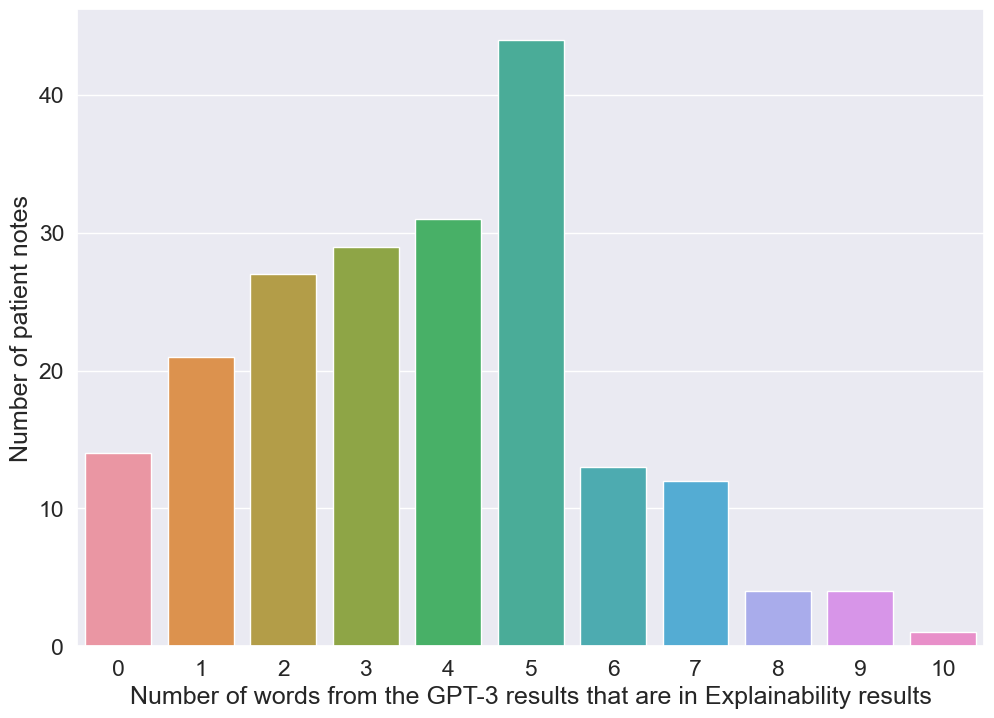

In [7]:
# Plot the distribution of the number of words from the ground truth that are in the token prediction

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)

ax = sns.countplot(x="count", data=df)
ax.set(xlabel='Number of words from the GPT-3 results that are in Explainability results', ylabel='Number of patient notes')
plt.show()


/var/folders/yw/91gjyrms7zx1tjywmz45vsmh0000gn/T/ipykernel_65241/3676026962.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['cosine_similarity'], kde=False)


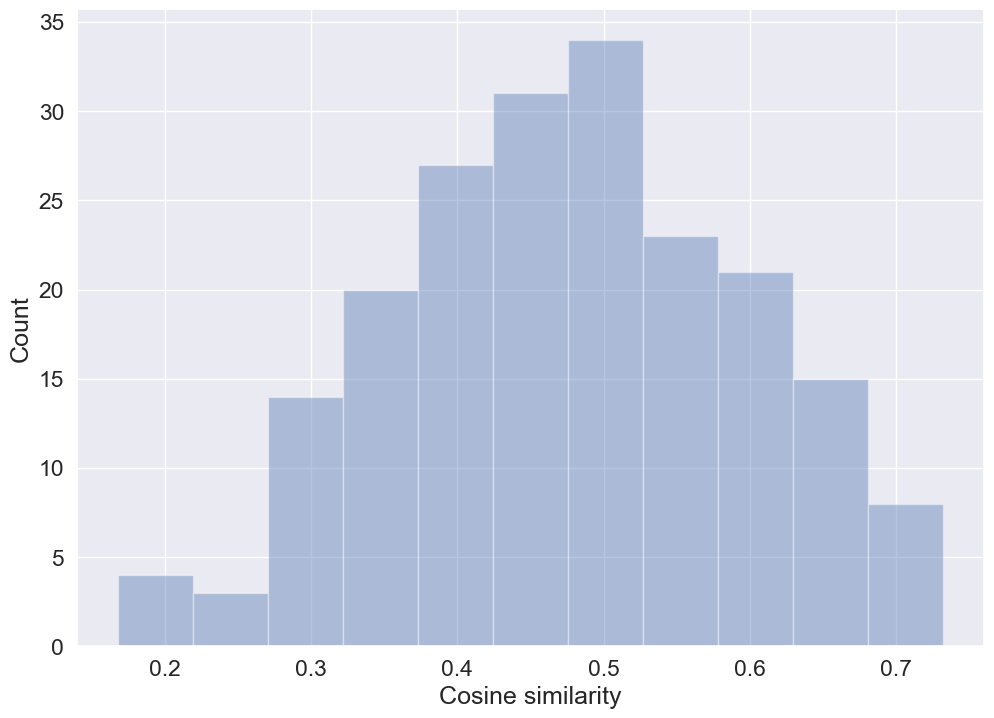

In [73]:
# Plot the distribution of the cosine similarity
ax = sns.distplot(df['cosine_similarity'], kde=False)
ax.set(xlabel='Cosine similarity', ylabel='Count')
plt.show()

In [28]:
df['count'].value_counts()

count
5    37
4    33
3    29
2    27
1    24
6    23
0    14
7    10
8     2
9     1
Name: count, dtype: int64

In [16]:
# token_prediction: [(word, probability), (word, probability), ...]
# ground_truth: [word, word, ...] where the first word is the most important word and the last word is the least important word
# Evaluate the prediction results by comparing the token_prediction with ground_truth based on the following metrics:
# 1. Cosine similarity
# 2. Jaccard similarity
# Get embeddings 


<class 'list'>


ValueError: could not convert string to float: '[CLS]'